# Imports

In [0]:
import zipfile
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import csv

# Prepare Google Drive (for persistent storage)

In [3]:
from google.colab import drive
GOOGLE_DRIVE_MOUNT = "/content/gdrive"
drive.mount(GOOGLE_DRIVE_MOUNT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Download data from Kaggle

In [4]:
# we need to use python 3 version of Kaggle!
# remove python 2 version with `pip uninstall kaggle`
! pip3 install kaggle --upgrade

    100% |████████████████████████████████| 61kB 5.1MB/s 
    100% |████████████████████████████████| 235kB 14.3MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [5]:
# get <token> from https://www.kaggle.com/<user>/account, click "Create New API Token", open json file
! KAGGLE_USERNAME=<user> KAGGLE_KEY=<token> kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip

100% 7.37G/7.37G [01:12<00:00, 143MB/s]
100% 7.37G/7.37G [01:12<00:00, 109MB/s]


In [0]:
# open zip file, will read everything from it
zf = zipfile.ZipFile("train_simplified.zip")

# Data generators from disk (no need to store in RAM)

In [7]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

# Images generator

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

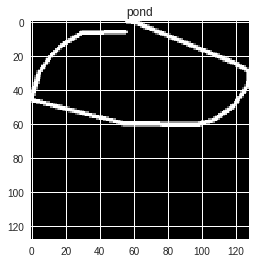

In [12]:
b = images_and_labels_generator(32).next()
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

# Augmentation example

Using TensorFlow backend.


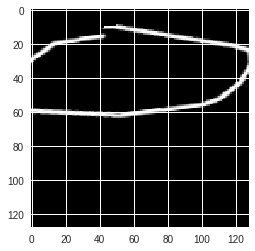

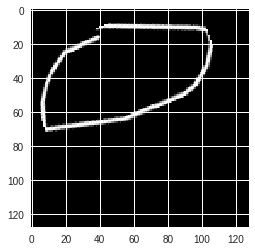

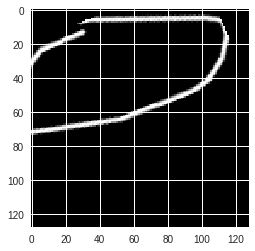

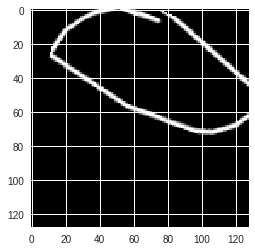

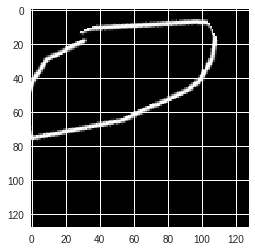

In [13]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    cval=255
)

image = b[0][10, :, :]

# add 3 channels to image
image = np.tile(np.expand_dims(image, axis=2), (1, 1, 3))

# 5 random augmentations
for _ in range(5):
    plt.imshow(image_gen.random_transform(image)[:, :, 0])
    plt.show()

# Train simple network

In [0]:
import tensorflow as tf
import keras
from keras import backend as K

In [0]:
# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [16]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        ### YOUR CODE HERE: normalize images!
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [18]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization

In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    ### YOUR CODE HERE: replace with a better model! Batch normalization really helps!
    
    model.add(Conv2D(16, (3, 3), padding='same', activation='elu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(Conv2D(16, (3, 3), padding='same', activation='elu'))
    model.add(GlobalAveragePooling2D())

    model.add(Dense(64, activation='elu'))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

In [21]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_2 (Dense)              (None, 340)               22100     
Total params: 25,668
Trainable params: 25,668
Non-trainable params: 0
_________________________________________________________________


In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = 100
EPOCHS = 5

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [25]:
import os
GOOGLE_DRIVE_ROOT = GOOGLE_DRIVE_MOUNT + "/" + filter(lambda x: x[0] != '.', os.listdir(GOOGLE_DRIVE_MOUNT))[0]
print GOOGLE_DRIVE_ROOT

# will save checkpoints to Google Drive
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_ROOT + "/model_{}"
print CHECKPOINT_TEMPLATE

/content/gdrive/My Drive
/content/gdrive/My Drive/model_{}


In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 2
# model = load_model(CHECKPOINT_TEMPLATE.format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [27]:
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 3/5
100/100 [==============================] - 7s 73ms/step - loss: 5.4181 - categorical_accuracy: 0.0128 - top_3_accuracy: 0.0431
Model saved in /content/gdrive/My Drive/model_2
Epoch 4/5
100/100 [==============================] - 4s 41ms/step - loss: 5.2892 - categorical_accuracy: 0.0209 - top_3_accuracy: 0.0616
Model saved in /content/gdrive/My Drive/model_3
Epoch 5/5
100/100 [==============================] - 4s 41ms/step - loss: 5.1783 - categorical_accuracy: 0.0206 - top_3_accuracy: 0.0644
Model saved in /content/gdrive/My Drive/model_4


# Score test set

In [0]:
# download test set
! KAGGLE_USERNAME=<user> KAGGLE_KEY=<token> kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv

 93%|███████████████████████████████████▍  | 55.0M/59.0M [00:01<00:00, 45.1MB/s]
100%|██████████████████████████████████████| 59.0M/59.0M [00:01<00:00, 42.1MB/s]


In [0]:
def test_csv_iterator(batch_size):
    with open("test_simplified.csv", "r") as f:
        batch_keys = []
        batch_images = []
        f.readline()  # skip header
        for line in csv.reader(f, delimiter=',', quotechar='"'):
            batch_keys.append(line[0])
            batch_images.append(draw_it(line[2]))
            if len(batch_images) == batch_size:
                batch_images = np.stack(batch_images, axis=0)
                batch_images = np.expand_dims(batch_images, -1)
                batch_images = batch_images.astype('float32')
                ### YOUR CODE HERE: normalize batch_images the same way as during training!
                yield batch_keys, batch_images
                batch_keys = []
                batch_images = []
        if batch_images:  # last batch
            batch_images = np.stack(batch_images, axis=0)
            batch_images = np.expand_dims(batch_images, -1)
            batch_images = batch_images.astype('float32')
            ### YOUR CODE HERE: normalize batch_images the same way as during training!
            yield batch_keys, batch_images

In [0]:
! wc -l test_simplified.csv

112200 test_simplified.csv


In [0]:
with open("submission.csv", "w", buffering=1*1024*1024) as f:
    f.write("key_id,word\n")
    for batch_keys, batch_images in tqdm.tqdm(test_csv_iterator(BATCH_SIZE), total=np.ceil(112200./BATCH_SIZE)):
        probas = model.predict_proba(batch_images, BATCH_SIZE)
        top_3_classes = np.argsort(probas, axis=1)[:, [-1, -2, -3]]
        labels = map(lambda x: " ".join("_".join(class_labels[idx].split()) for idx in x), top_3_classes)
        for key, labels in zip(batch_keys, labels):
            f.write(key + "," + labels + "\n")

In [0]:
! wc -l submission.csv

112200 submission.csv


In [0]:
# submit to kaggle
! KAGGLE_USERNAME=<user> KAGGLE_KEY=<token> kaggle competitions submit quickdraw-doodle-recognition -f submission.csv -m "My precious"

100%|███████████████████████████████████████| 4.44M/4.44M [00:10<00:00, 456kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge